In [7]:
#Example code to calculate gap
import numpy as np
from pyscf import gto, scf, lib, mcscf
import math
import time
import os
from tools import sign_control, util
from systems.niochain import NiOChain

def calc_gap(dist=2,nio_dist=1.6,fn="logs/nio.log"):
    #dist -- distance between NiO fragments
    #nio_dist -- Ni O distance
    geom = NiOChain(4,dist=dist,nio_dist=nio_dist,fn=fn)
    las = geom.make_las_state_average()
    
    #Build LAS states
    print("Initiating LAS Model Space...")
    start = time.perf_counter()
    las.lasci_()
    las.ci = sign_control.fix_sign(las)
    stop = time.perf_counter()
    print("Done. Time elapsed:",stop-start,"seconds")
    las.dump_spaces()
        
    #Run LASSI
    print("Running LASSI...")
    start = time.perf_counter()
    from mrh.my_pyscf import lassi
    lsi = lassi.LASSI(las)
    energies_lassi, civecs_lassi = lsi.kernel()
    civecs_lassi = lsi.get_sivec_vacuum_shuffle(state=0) #Sign fixing
    stop = time.perf_counter()
    print("Done. Time elapsed:",stop-start,"seconds")
    
    hartree_to_ev = 27.2114
    de = energies_lassi[1] - energies_lassi[0]
    gap = de * hartree_to_ev
    print("Gap:",np.round(gap,2),"eV")

    las_charges = util.las_charges(las)
    data = {"energies_lassi":energies_lassi,
            "civecs":civecs_lassi,
            "charges":las_charges,
            "nfrags":geom.nfrags,
            "dist":geom.dist,
            "mf_coeff":geom.mf_coeff,
            "mf_occ":geom.mf_occ,
            "mf_ene":geom.mf_ene,
           }
    
    return data, gap

data, gap = calc_gap(dist=2.5,nio_dist=2.1)

overwrite output file: logs/nio.log
Initiating LAS Model Space...
Done. Time elapsed: 22.211530586704612 seconds
Running LASSI...
Done. Time elapsed: 0.9164449400268495 seconds
Gap: 3.81 eV


1.0
1.75
2.5


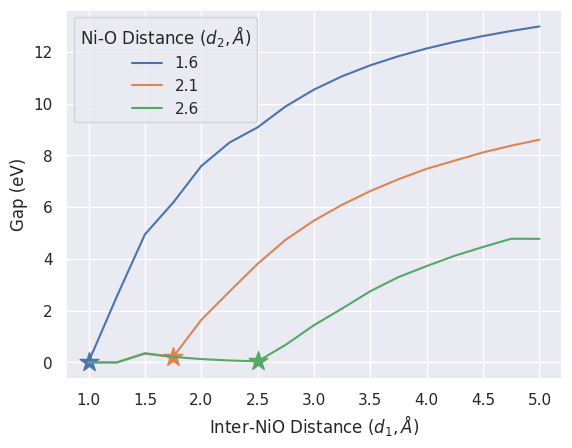

In [5]:
import numpy as np
from pyscf import gto, scf, lib, mcscf
import time
import pandas as pd
import math
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from dsk.las import sign_control, hcircle, util
from dsk.pickle import load_pkl, dump_pkl
from dsk.las.hcircle import HCircle, HDMRG

from dsk.pickle import dump_pkl, load_pkl
df = load_pkl("niores4nio160.pkl")
df2 = load_pkl("niores4nio210.pkl")
df = pd.concat([df,df2])
df2 = load_pkl("niores4nio260.pkl")
df = pd.concat([df,df2])
for d in np.unique(df["nio_dist"]):
    df2 = df.query("nio_dist == @d")
    for i in df2.index.tolist()[::-1]:
        if df2["gap"][i] < 0.25:
            print(df2.iloc[i]["dist"])
            plt.scatter(df2.iloc[i]["dist"],df2.iloc[i]["gap"],marker="*",s=200)
            # plt.plot(df2["dist"].iloc[i:],df2["gap"].iloc[i:],label=str(np.round(d,2)))
            break
    plt.plot(df2["dist"],df2["gap"],label=str(np.round(d,2)))
plt.ylabel("Gap (eV)")
plt.xlabel("Inter-NiO Distance ($d_1, \AA$)")
plt.legend(title="Ni-O Distance ($d_2, \AA$)")
# plt.axvline(2.5,linestyle="dashed")
# plt.savefig("periodiclas/figures/nio_dist.png",dpi=500)